# Матирование видео с SAM 2 Matting

В этом ноутбуке показына примеры использования Sam 2, переученной на матирование.

<a target="_blank" href="https://colab.research.google.com/github/facebookresearch/sam2/blob/main/notebooks/video_predictor_example.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

## Настройка среды

Если запускаете локально, то установите предварительно записимости. Если используете colab, запускайте на гугл диске, где есть файлы sam2 и установите using_colab = True

In [1]:
using_colab = True

In [2]:
if using_colab:
  import sys
  !{sys.executable} -m pip install hydra-core > /dev/null
  !{sys.executable} -m pip install iopath > /dev/null

## Настройка

In [3]:
import os
# if using Apple MPS, fall back to CPU for unsupported ops
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image
from hydra import initialize_config_dir
from hydra.core.global_hydra import GlobalHydra
from hydra.utils import instantiate
import sys
from google.colab import drive
import random

In [4]:
if using_colab:
  drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
sys.path.append('/content/drive/My Drive/Matting Project/sam2')

In [6]:
from sam2.build_sam_matting import build_sam2_video_predictor_matting

In [7]:
# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )

using device: cuda


### Загрузка матирующей модели SAM 2

In [8]:
config_dir = "/content/drive/My Drive/Matting Project/configs"
if GlobalHydra.instance().is_initialized():
    GlobalHydra.instance().clear()
initialize_config_dir(config_dir=config_dir, version_base="1.1")

hydra.initialize_config_dir()

In [9]:
checkpoint = "/content/drive/My Drive/Matting Project/checkpoints/sam2.1_hiera_large_matting.pt"
model_cfg = "sam2.1_hiera_l_predictor.yaml"
predictor = build_sam2_video_predictor_matting(model_cfg, checkpoint)

In [10]:
def show_mask(mask, ax, obj_id=None, random_color=False):
    """
    Отображает маску с учётом прозрачности.

    Аргументы:
        mask: Альфа-маска (float32, значения от 0 до 1), определяющая прозрачность.
        ax: Объект осей matplotlib для отображения.
        obj_id: Идентификатор объекта для выбора цвета (используется, если random_color=False).
        random_color: Если True, используется случайный цвет; иначе цвет из colormap.
    """
    if random_color:
        # Генерация случайного цвета (RGBA)
        color = np.concatenate([np.random.random(3), np.array([1.0])], axis=0)
    else:
        # Выбор цвета из colormap
        cmap = plt.get_cmap("tab10")
        cmap_idx = 0 if obj_id is None else obj_id
        color = np.array([*cmap(cmap_idx)[:3], 1.0])  # Последний канал — непрозрачность (альфа = 1)

    h, w = mask.shape[-2:]  # Размеры маски
    alpha = mask.reshape(h, w)  # Используем значения маски как альфа-канал (0–1)
    mask_image = np.zeros((h, w, 4))  # Создаём пустой RGBA-массив
    mask_image[..., :3] = color[:3]  # Устанавливаем цвет (RGB)
    mask_image[..., 3] = alpha  # Альфа-канал берётся из маски

    ax.imshow(mask_image)


def show_points(coords, labels, ax, marker_size=200):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))

In [11]:
def create_composite(fgr, pha, background):
    """
    Смешивает передний план с альфа-каналом и фоновое изображение.
    """
    # Преобразуем изображения в массивы
    fgr = np.array(fgr) / 255.0  # Нормализуем от 0 до 1
    pha = np.array(pha) / 255.0  # Нормализуем от 0 до 1
    background = np.array(background) / 255.0  # Нормализуем от 0 до 1

    # Изменяем размер background до размера fgr/pha
    background = np.array(Image.fromarray((background * 255).astype(np.uint8)).resize((fgr.shape[1], fgr.shape[0]))) / 255.0

    # Композиция: alpha * foreground + (1 - alpha) * background
    composite = (pha[..., None] * fgr) + ((1 - pha[..., None]) * background)
    return (composite * 255).astype(np.uint8)  # Возвращаем в диапазон [0, 255]

In [12]:
backgrounds_path = "/content/drive/My Drive/Matting Project/Backgrounds"
background_files = os.listdir(backgrounds_path)

#### Выбор видео-примера

Предполагаем, что видео хранится в формате jpeg и начинается с `00000.jpg`.

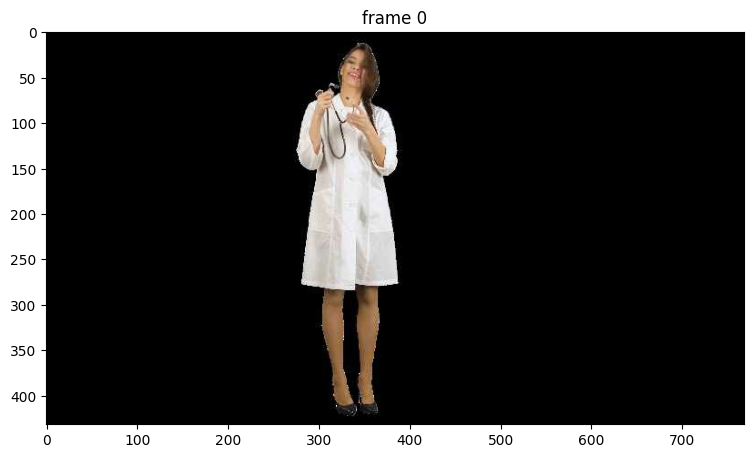

In [26]:
# `video_dir` a directory of JPEG frames with filenames like `<frame_index>.jpg`
video_dir = "/content/drive/My Drive/Matting Project/sam2/notebooks/videos/0004"

# scan all the JPEG frame names in this directory
frame_names = [
    p for p in os.listdir(video_dir)
    if os.path.splitext(p)[-1] in [".jpg", ".jpeg", ".JPG", ".JPEG"]
]
frame_names.sort(key=lambda p: int(os.path.splitext(p)[0]))

# take a look the first video frame
frame_idx = 0
plt.figure(figsize=(9, 6))
plt.title(f"frame {frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[frame_idx])))

#### Инициализируем начальную позицию

In [27]:
torch.cuda.empty_cache()

In [28]:
import gc
gc.collect()

42896

In [29]:
inference_state = predictor.init_state(video_path=video_dir)

frame loading (JPEG): 100%|██████████| 276/276 [00:12<00:00, 21.71it/s]


### Пример 1: матируем и отслеживаем один объект

Чтобы стереть предыдущие точки, можно использовать `reset_state`.

In [ ]:
predictor.reset_state(inference_state)

#### Этап 1: добавляем клик

Добавляем первый положительный клик (x, y) = (340, 200) через `add_new_points_or_box` API.

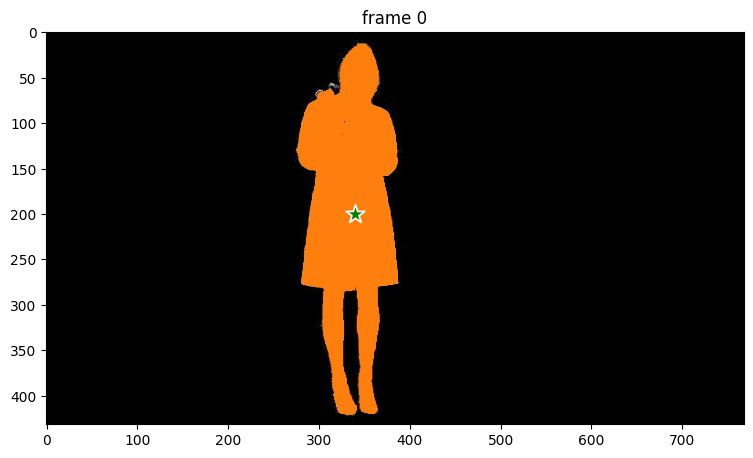

In [30]:
ann_frame_idx = 0  # the frame index we interact with
ann_obj_id = 1  # give a unique id to each object we interact with (it can be any integers)

# Let's add a positive click at (x, y) = (210, 350) to get started
points = np.array([[340, 200]], dtype=np.float32)
# for labels, `1` means positive click and `0` means negative click
labels = np.array([1], np.int32)
_, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    points=points,
    labels=labels,
)

# show the results on the current (interacted) frame
plt.figure(figsize=(9, 6))
plt.title(f"frame {ann_frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[ann_frame_idx])))
show_points(points, labels, plt.gca())
show_mask(torch.sigmoid(out_mask_logits[0]).cpu().numpy(), plt.gca(), obj_id=out_obj_ids[0])

#### Этап 2 : движемся по кадрам видео

Используем `propagate_in_video` API.

propagate in video: 100%|██████████| 276/276 [05:04<00:00,  1.10s/it]


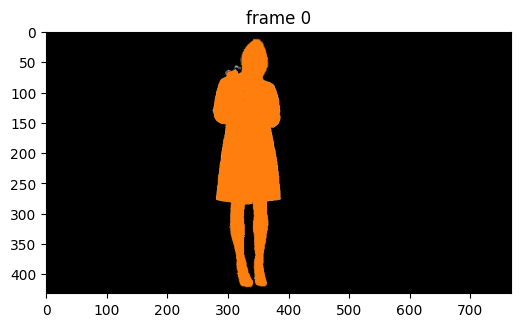

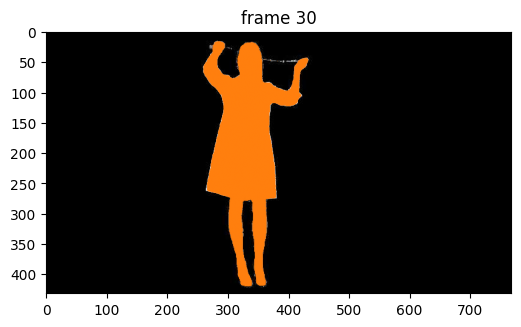

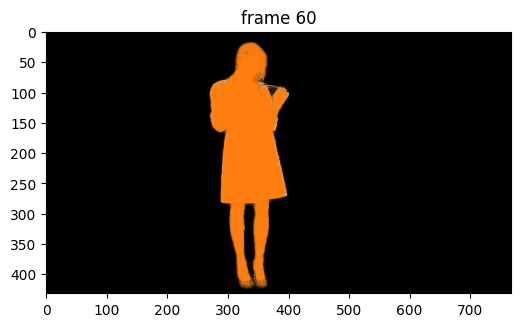

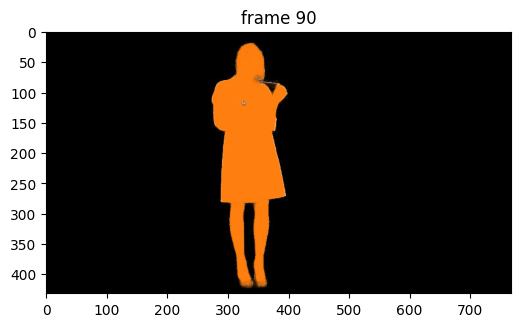

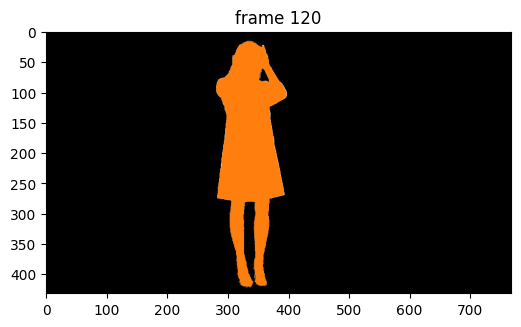

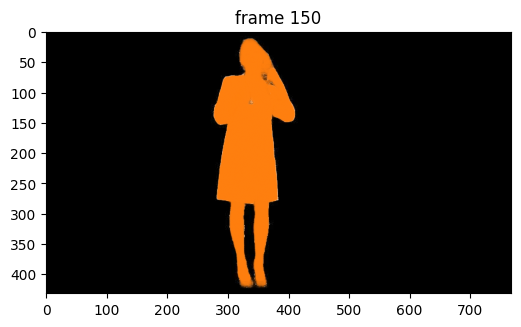

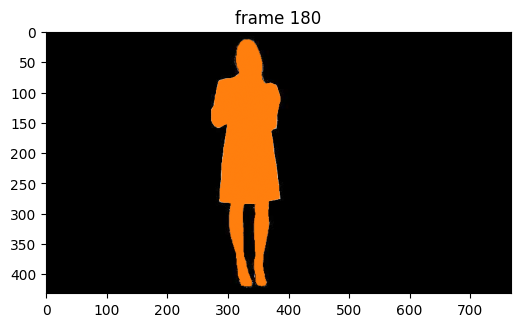

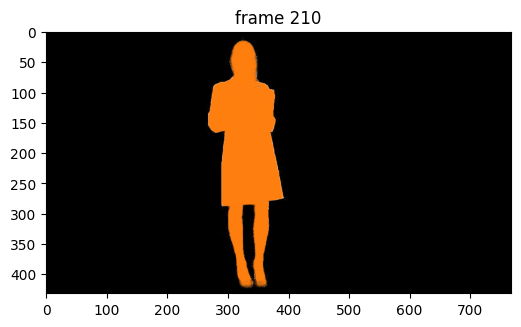

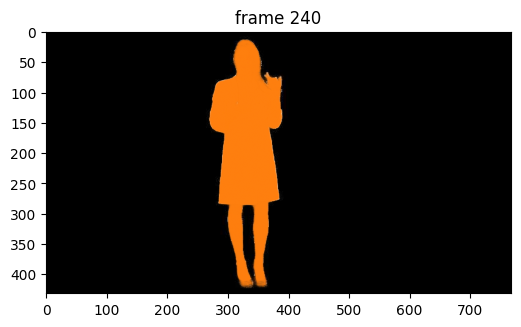

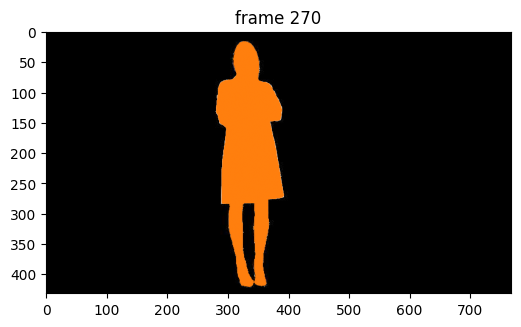

In [31]:
# run propagation throughout the video and collect the results in a dict
video_segments = {}  # video_segments contains the per-frame segmentation results
for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state):
    video_segments[out_frame_idx] = {
        out_obj_id: torch.sigmoid(out_mask_logits[i]).cpu().numpy()
        for i, out_obj_id in enumerate(out_obj_ids)
    }

# render the segmentation results every few frames
vis_frame_stride = 30
plt.close("all")
for out_frame_idx in range(0, len(frame_names), vis_frame_stride):
    plt.figure(figsize=(6, 4))
    plt.title(f"frame {out_frame_idx}")
    plt.imshow(Image.open(os.path.join(video_dir, frame_names[out_frame_idx])))
    for out_obj_id, out_mask in video_segments[out_frame_idx].items():
        show_mask(out_mask, plt.gca(), obj_id=out_obj_id)

#### Этап 3 : добавляем задний фон

In [32]:
background_file = random.choice(background_files)
background_image = Image.open(os.path.join(backgrounds_path, background_file)).convert("RGB")

In [33]:
for out_frame_idx in range(0, len(frame_names), vis_frame_stride):
    frame_name = frame_names[out_frame_idx]

    # Загружаем кадр
    frame_image = Image.open(os.path.join(video_dir, frame_name)).convert("RGB")

    # Загружаем маску (альфа-канал) для этого кадра
    # Предположим, что `video_segments[out_frame_idx]` содержит альфа-маски
    if out_frame_idx in video_segments:
        segment = video_segments[out_frame_idx]

        # Для примера используем первую маску (можно изменить, если их несколько)
        alpha_mask = segment[out_obj_ids[0]][0]  # Предположим, что идентификатор объекта 0
        if alpha_mask is not None:
            # Преобразуем альфа-маску в изображение (черно-белое)
            alpha_image = Image.fromarray((alpha_mask * 255).astype(np.uint8)).convert("L")

            # Создаем композитное изображение с альфа-каналом
            composite_image = create_composite(frame_image, alpha_image, background_image)

            # Отображаем результат с помощью plt
            plt.figure(figsize=(6, 4))
            plt.imshow(composite_image)
            plt.title(f"frame {out_frame_idx}")
            plt.axis('off')  # Скрыть оси
            plt.show()

Output hidden; open in https://colab.research.google.com to view.

### Пример 2: матирование с помощью боксов

Удаляем точки с помощью `reset_state`.

In [41]:
predictor.reset_state(inference_state)

Добавляем бокс в формате (x_min, y_min, x_max, y_max) = (260, 10, 400, 430) через `add_new_points_or_box` API.

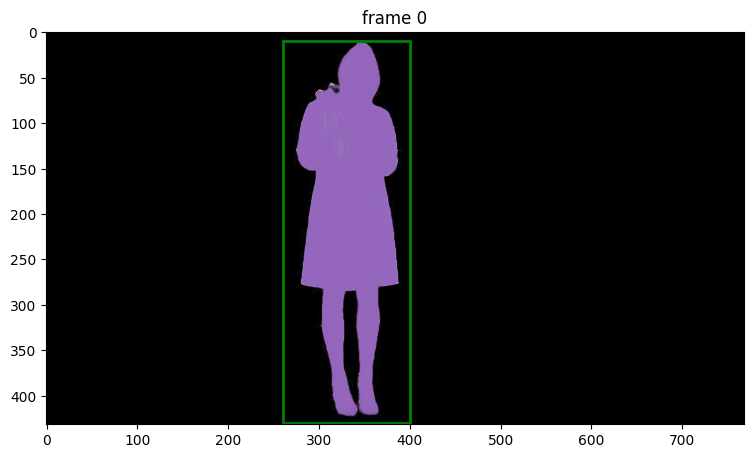

In [42]:
ann_frame_idx = 0  # the frame index we interact with
ann_obj_id = 4  # give a unique id to each object we interact with (it can be any integers)

# Let's add a box at (x_min, y_min, x_max, y_max) = (260, 10, 400, 430) to get started
box = np.array([260, 10, 400, 430], dtype=np.float32)
_, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    box=box,
)

# show the results on the current (interacted) frame
plt.figure(figsize=(9, 6))
plt.title(f"frame {ann_frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[ann_frame_idx])))
show_box(box, plt.gca())
show_mask(torch.sigmoid(out_mask_logits[0]).cpu().numpy(), plt.gca(), obj_id=out_obj_ids[0])

Движемся по видео, используя `propagate_in_video` API.

propagate in video: 100%|██████████| 276/276 [05:04<00:00,  1.10s/it]


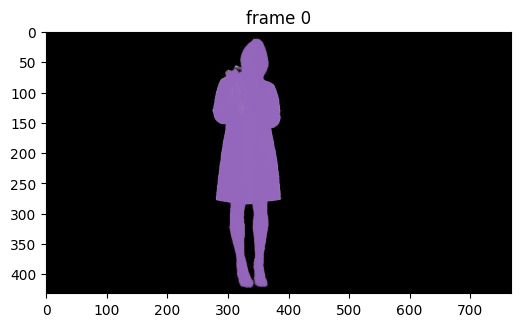

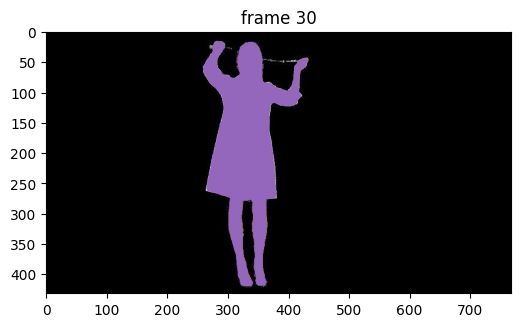

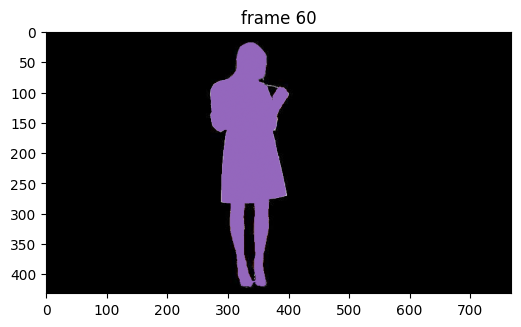

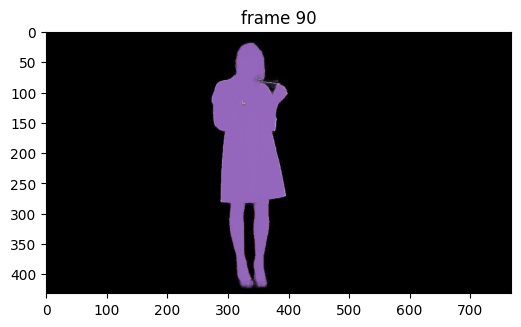

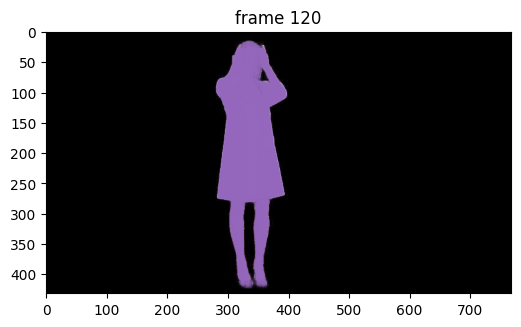

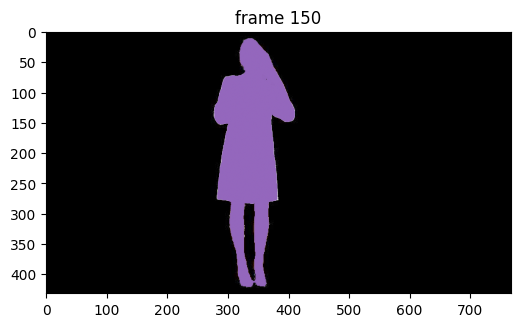

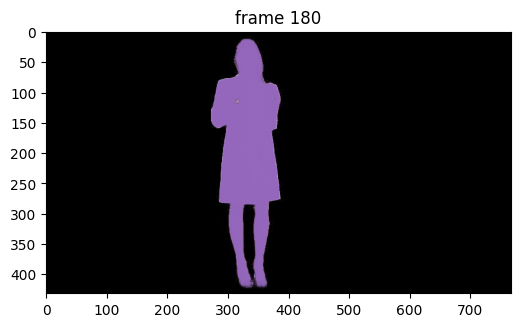

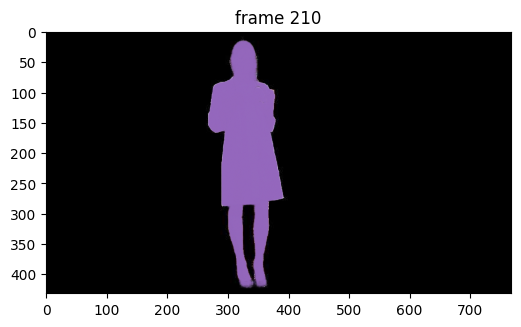

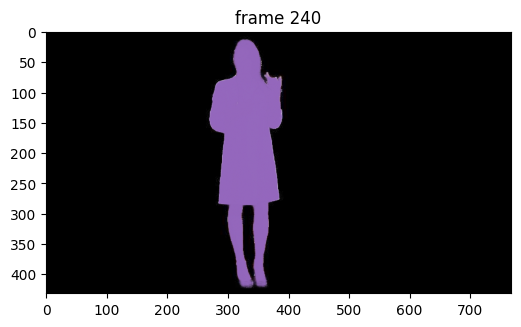

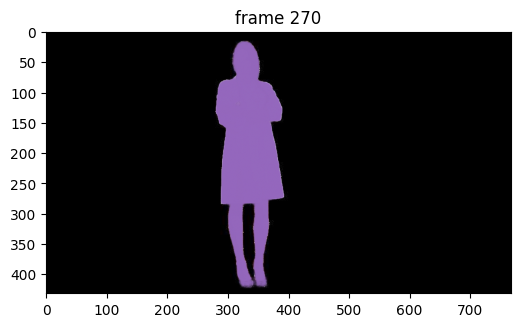

In [43]:
# run propagation throughout the video and collect the results in a dict
video_segments = {}  # video_segments contains the per-frame segmentation results
for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state):
    video_segments[out_frame_idx] = {
        out_obj_id: torch.sigmoid(out_mask_logits[i]).cpu().numpy()
        for i, out_obj_id in enumerate(out_obj_ids)
    }

# render the segmentation results every few frames
vis_frame_stride = 30
plt.close("all")
for out_frame_idx in range(0, len(frame_names), vis_frame_stride):
    plt.figure(figsize=(6, 4))
    plt.title(f"frame {out_frame_idx}")
    plt.imshow(Image.open(os.path.join(video_dir, frame_names[out_frame_idx])))
    for out_obj_id, out_mask in video_segments[out_frame_idx].items():
        show_mask(out_mask, plt.gca(), obj_id=out_obj_id)

Добавляем фон

In [46]:
background_file = random.choice(background_files)
background_image = Image.open(os.path.join(backgrounds_path, background_file)).convert("RGB")

In [47]:
for out_frame_idx in range(0, len(frame_names), vis_frame_stride):
    frame_name = frame_names[out_frame_idx]

    # Загружаем кадр
    frame_image = Image.open(os.path.join(video_dir, frame_name)).convert("RGB")

    # Загружаем маску (альфа-канал) для этого кадра
    # Предположим, что `video_segments[out_frame_idx]` содержит альфа-маски
    if out_frame_idx in video_segments:
        segment = video_segments[out_frame_idx]

        # Для примера используем первую маску (можно изменить, если их несколько)
        alpha_mask = segment[out_obj_ids[0]][0]  # Предположим, что идентификатор объекта 0
        if alpha_mask is not None:
            # Преобразуем альфа-маску в изображение (черно-белое)
            alpha_image = Image.fromarray((alpha_mask * 255).astype(np.uint8)).convert("L")

            # Создаем композитное изображение с альфа-каналом
            composite_image = create_composite(frame_image, alpha_image, background_image)

            # Отображаем результат с помощью plt
            plt.figure(figsize=(6, 4))
            plt.imshow(composite_image)
            plt.title(f"frame {out_frame_idx}")
            plt.axis('off')  # Скрыть оси
            plt.show()

Output hidden; open in https://colab.research.google.com to view.